In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import scipy as sp
import inspect
import os
import sys
import time

import paragami

from copy import deepcopy

import bnpregcluster_runjingdev.regression_mixture_lib as gmm_lib

np.random.seed(42) # nothing special about this seed (we hope)!

In [69]:
reg_params = dict()
#datafile = 'fits/transformed_gene_regression_df7_degree3_genes10000.npz'
#datafile = 'fits/transformed_gene_regression_df7_degree3_genes1000.npz'
#datafile = 'fits/shrunken_transformed_gene_regression_df$_degree3_genes1000.npz'
#datafile = 'fits/shrunken_transformed_gene_regression_df7_degree3_genes1000.npz'
datafile = 'fits/shrunken_transformed_gene_regression_df4_degree3_genes1000.npz'
with np.load(datafile) as infile:
    reg_params['y_info'] = infile['y_info']
    reg_params['beta_mean'] = infile['transformed_beta_mean']
    reg_params['beta_info'] = infile['transformed_beta_info']
    df = infile['df']
    degree = infile['degree']
    
num_genes = reg_params['beta_mean'].shape[0]
obs_dim = reg_params['beta_mean'].shape[1]

num_components = 30

analysis_name = 'transformed_gene_regression_df{}_degree{}_genes{}_num_components{}_fit'.format(
    df, degree, num_genes, num_components)

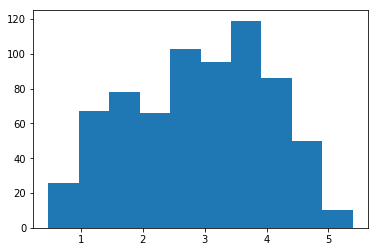

In [64]:
plt.hist(reg_params['y_info']);

In [65]:
prior_params = gmm_lib.get_base_prior_params(obs_dim, num_components)
prior_params_pattern = gmm_lib.get_prior_params_pattern(obs_dim, num_components)
prior_params_pattern.validate_folded(prior_params)
gmm = gmm_lib.GMM(num_components, prior_params, reg_params)

In [66]:
print('Running k-means init.')
kmeans_params = \
    gmm_lib.kmeans_init(gmm.reg_params,
                        gmm.num_components, 50)
print('Done.')
init_gmm_params = dict()
init_gmm_params['centroids'] = kmeans_params['centroids']
init_gmm_params['stick_propn_mean'] = np.zeros(gmm.num_components - 1)
init_gmm_params['stick_propn_info'] = np.ones(gmm.num_components - 1)

init_x = gmm.gmm_params_pattern.flatten(init_gmm_params, free=True)

Running k-means init.
Done.


In [67]:
gmm.conditioned_obj.reset() # Reset the logging and iteration count.
gmm.conditioned_obj.set_print_every(1)

opt_time = time.time()
gmm_opt, init_x2 = gmm.optimize(init_x, gtol=1e-2)
opt_time = time.time() - opt_time

Iter 0: f = -41766.81949873
Iter 1: f = -42338.02951151
Iter 2: f = -43049.34542484
Iter 3: f = -43699.82602179
Iter 4: f = -44174.49239110
Iter 5: f = -44030.10642922
Iter 6: f = -44369.07436888
Iter 7: f = -44548.09240150
Iter 8: f = -44613.85665007
Iter 9: f = -44771.02979495
Iter 10: f = -44750.78822885
Iter 11: f = -44810.47503020
Iter 12: f = -44856.64930440
Iter 13: f = -44876.70936440
Iter 14: f = -44834.23618704
Iter 15: f = -44922.05267845
Iter 16: f = -44955.88477297
Iter 17: f = -44965.44420918
Iter 18: f = -45000.23512669
Iter 19: f = -45021.50181032
Iter 20: f = -45036.08307031
Iter 21: f = -45046.34814842
Iter 22: f = -45054.82841607
Iter 23: f = -45061.74333874
Iter 24: f = -45061.84552346
Iter 25: f = -45068.47132043
Iter 26: f = -45078.08810181
Iter 27: f = -45086.60878352
Iter 28: f = -45040.15422138
Iter 29: f = -45093.82611212
Iter 30: f = -45098.69435598
Iter 31: f = -45100.77836372
Iter 32: f = -45104.10259506
Iter 33: f = -45104.99806295
Iter 34: f = -45103.7110

In [68]:
tic = time.time()
# Note that h_cond is the Hessian.
h_cond = gmm.update_preconditioner(init_x2)
opt_time += time.time() - tic

KeyboardInterrupt: 

In [ ]:
h_cond.shape, gmm.kl_obj.grad(init_x2).shape

In [ ]:
gmm.conditioned_obj.reset()
tic = time.time()
gmm_opt, gmm_opt_x = gmm.optimize_fully(
    init_x2, verbose=True, kl_hess=h_cond)
opt_time += time.time() - tic
print('Optimization time: {} seconds'.format(opt_time))

In [ ]:
opt_gmm_params = gmm.gmm_params_pattern.fold(gmm_opt_x, free=True)
print(opt_gmm_params.keys())
e_z = gmm.get_e_z(opt_gmm_params)
print(np.sort(np.sum(e_z, axis=0)))

In [ ]:
loglik_obs_by_nk = gmm_lib.get_loglik_obs_by_nk(opt_gmm_params, gmm.reg_params)

In [ ]:
# for i in range(num_components):
#     print('{:0.5}\t{:0.5}'.format(np.sum(e_z, axis=0)[i], np.std(e_z, axis=0)[i]))

z_sum = np.sum(e_z, axis=0)
small_clusters = np.squeeze(np.argwhere(z_sum < 1.1))
small_clusters
obs_k = np.full(gmm.num_obs, int(-1))
for n in range(gmm.num_obs):
    obs_k[n] = np.argmax(e_z[n, :])

# Plot one of the small components
k_small = 5
n = int(np.argwhere(obs_k == small_clusters[k_small]))

# Get the top alternative components
top_components = np.argsort(-1 * loglik_obs_by_nk[n, :])[0:10]

f, axarr = plt.subplots(1, figsize=(15,8))
this_plot = axarr
this_plot.plot(gmm.reg_params['beta_mean'][n, :], color = 'red');
this_plot.set_ylabel('transformed coefficient')
this_plot.set_xlabel('index')
this_plot.set_title('gene number {}'.format(n))

# draw from the variational distribution to plot uncertainties
for j in range(60): 
    transformed_beta_draw = np.random.multivariate_normal(
        gmm.reg_params['beta_mean'][n, :], \
         np.linalg.inv(gmm.reg_params['beta_info'][n, :, :]))
    this_plot.plot(
        transformed_beta_draw, color = 'red', alpha = 0.08, linewidth=4);

for k in top_components:
    if k != k_small:
        this_plot.plot(opt_gmm_params['centroids'][k, :],
                       color = 'lightblue', linewidth=2);

k = np.argmax(e_z[n, :])
this_plot.plot(opt_gmm_params['centroids'][k, :], color = 'limegreen', linewidth=3);


In [ ]:
# Sanity check with a figure

f, axarr = plt.subplots(2, 3, figsize=(15,8))

plot_inds = np.random.choice(gmm.num_obs, 6, replace=False)
for i in range(6):
    n = plot_inds[i]
    this_plot = axarr[int(np.floor(i / 3)), i % 3] 
    this_plot.plot(gmm.reg_params['beta_mean'][n, :], color = 'red');
    this_plot.set_ylabel('transformed coefficient')
    this_plot.set_xlabel('index')
    this_plot.set_title('gene number {}'.format(n))

    # draw from the variational distribution to plot uncertainties
    for j in range(30): 
        transformed_beta_draw = np.random.multivariate_normal(
            gmm.reg_params['beta_mean'][n, :], \
             np.linalg.inv(gmm.reg_params['beta_info'][n, :, :]))

        this_plot.plot(
            transformed_beta_draw, color = 'red', alpha = 0.08);

    k = np.argmax(e_z[n, :])
    this_plot.plot(opt_gmm_params['centroids'][k, :], color = 'limegreen', linewidth=3);

f.tight_layout()

In [ ]:
save_dict = deepcopy(gmm_opt)
save_dict['df'] = df
save_dict['degree'] = degree
save_dict['datafile'] = datafile
save_dict['num_components'] = num_components
save_dict['gmm_params_pattern_json'] = \
    gmm.gmm_params_pattern.to_json()
save_dict['opt_gmm_params_flat'] = \
    gmm.gmm_params_pattern.flatten(opt_gmm_params, free=False)
save_dict['prior_params_pattern_json'] = \
    prior_params_pattern.to_json()
save_dict['prior_params_flat'] = \
    prior_params_pattern.flatten(prior_params, free=False)

save_dict['opt_time'] = opt_time

outfile = './fits/{}.npz'.format(analysis_name)
print('Saving to {}'.format(outfile))

np.savez_compressed(file=outfile, **save_dict)